# **Estudio inicial de como funciona un LLM**
___
### _Juan Jose Londoño Cardenas_
### _Universidad Politécnica de Madrid_
### _Junio/2025_

Como primera medida, haremos Fine Tuning de un modelo LLM preentrenado, con el fin de entender mas su uso al principio. Si se desea conocer desde cero la construccion de un LLM, se recomienda el otro repositorio donde partimos desde cero, en una regresion lineal basica y vamos avanzando hasta un LLM.

- https://github.com/lonj22803/estudio_doctorado_I

## **Introducción**

Los Large Language Models (LLMs) son modelos de lenguaje entrenados con enormes volúmenes de datos textuales. Estos modelos tienen la capacidad de generar texto coherente, responder preguntas, traducir idiomas y realizar una amplia variedad de tareas relacionadas con el procesamiento del lenguaje natural (PLN).

Lo que antes requería múltiples sistemas especializados —como modelos conversacionales basados en reglas, clasificadores emocionales o traductores automáticos— ahora puede ser abordado de forma unificada y más eficiente gracias a un solo modelo: un LLM. Esta convergencia tecnológica convierte a los LLMs en herramientas fundamentales que todo desarrollador debería conocer, afinar y saber utilizar.

#### Etapas principales en el ciclo de vida de un LLM

1. **Preentrenamiento**: El modelo se entrena con grandes corpus de texto no etiquetado para aprender los patrones y estructuras del lenguaje.

2. **Ajuste fino (Fine-tuning)**:  El modelo se adapta a tareas específicas utilizando conjuntos de datos etiquetados más pequeños.

3. **Inferencia**: El modelo ya entrenado se utiliza para realizar tareas concretas como generación de texto, clasificación, resumen, entre otras.

#### Objetivo de este notebook

En este notebook nos enfocaremos en la segunda etapa: el fine-tuning, donde tomaremos un modelo LLM preentrenado y lo adaptaremos a una tarea específica. Esta es una etapa clave para personalizar el comportamiento del modelo y obtener mejores resultados en dominios o aplicaciones particulares.

![Imagen_LLM_Etapas](Images/image4_a490096f94.png)

- Imagen tomada de https://www.datacamp.com/es/tutorial/fine-tuning-large-language-models?dc_referrer=https%3A%2F%2Fwww.google.com%2F
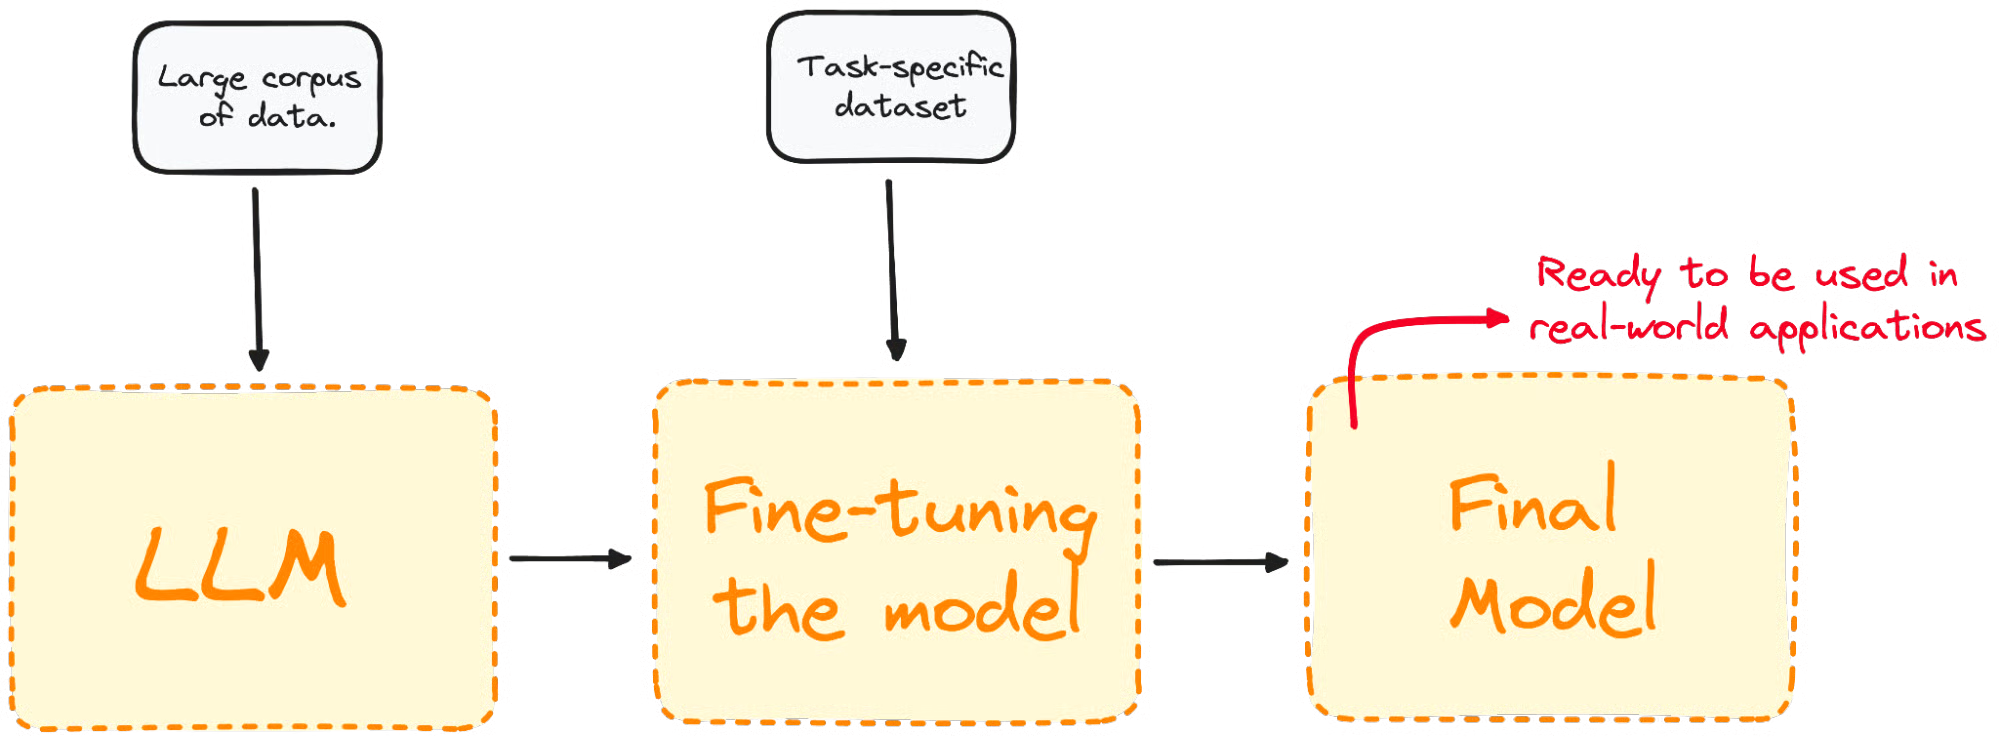

In [5]:
#Cargamos las librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importamos bases de datos
from datasets import load_dataset

# Importamos el modelo el cual sera gpt2 de Hugging Face
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from  transformers import GPT2ForSequenceClassification

#Libreria para el entrenamiento y evaluacion del modelo
from transformers import Trainer, TrainingArguments
import evaluate

#Revisamos si tenemos GPU disponible
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

from torch import cuda, backends

Usando dispositivo: cuda


In [6]:
dataset = load_dataset("mteb/tweet_sentiment_extraction")
df = pd.DataFrame(dataset['train'])

In [7]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3534
    })
})


In [8]:
"""
Usemos la base de datos de Twitter, que contiene tweets con sentimientos positivos, negativos y neutros.
0:Negative
1:Neutral
2:Positive
"""
df

,text,label
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
27476,wish we could come see u on Denver husband l...,0
27477,I`ve wondered about rake to. The client has ...,0
27478,Yay good for both of you. Enjoy the break - y...,2
27479,But it was worth it ****.,2


###  **El Tokenizador**

Los LLM no trabajan directamente con texto, sino que convierten el texto en números a través de un proceso llamado tokenización. Un tokenizador es una herramienta que divide el texto en unidades más pequeñas (tokens) y asigna un identificador numérico a cada token en un espacio vectorial de alta dimensionalidad que tiene que ver con el vocabulario del modelo.

Por eso, el segundo paso consiste en cargar un Tokenizer preentrenado y tokenizar nuestro conjunto de datos  que vamos a usar para Fine tuning para poder utilizarlo en el ajuste preciso.

In [9]:
#Usaremos el tokenizador de GPT-2, que es un modelo de lenguaje preentrenado de Hugging Face.
tokenizer= GPT2Tokenizer.from_pretrained("gpt2")
# Añadimos el token de fin de secuencia (eos_token) al tokenizador
"""
EOS_Token: Este token indica el final de una secuencia de texto. Es útil para modelos que generan texto, ya que les permite saber cuándo detenerse.
"""
tokenizer.pad_token = tokenizer.eos_token
# Tokenizamos el dataset
def tokenize_function(examples):
    """
    Tokeniza el texto de los ejemplos del dataset.
    :param examples:
    :return:
    """
    return tokenizer(examples["text"], truncation=True, padding="max_length")

tokenized_datasets = dataset.map(tokenize_function, batched=True)

#### Mejoramiento de requisitos de procesamiento

Creamos un subconjunto del dataset para que el entrenamiento sea mas rapido y no se nos acabe la memoria de la GPU, para la afinacion de nuestro modelo. El conjunto de entrenamiento se realizara para ajuste preciso del modelo, mientras que le conjunto de pruebas se usara para evaluar el modelo afinado.

In [10]:
# Reducimos el tamaño del dataset para entrenamiento y evaluación
# Esto es útil para pruebas rápidas y para evitar problemas de memoria en la GPU.
#Conjunto aleatorio de 1000 ejemplos para entrenamiento y 1000 para evaluación
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(3000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))

In [11]:
#Instanseamos el modelo de GPT-2 para clasificación de secuencias

#Tenemos tres clases: 0, 1 y 2, que corresponden a sentimientos negativos, neutros y positivos respectivamente, por eso especificamos num_labels=3.
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Importa la métrica de precisión (accuracy) desde la librería evaluate.
metrics = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """
    Función que calcula la métrica de precisión (accuracy) a partir de las predicciones del modelo.
    :param eval_pred: Tupla que contiene los logits (salidas sin normalizar del modelo) y las etiquetas reales.
    :return: Diccionario con el valor de la métrica de precisión.
    """
    logits, labels = eval_pred  # Se separan las predicciones y las etiquetas reales.
    predictions = np.argmax(logits, axis=-1)  # Se obtiene la clase predicha con mayor probabilidad.
    return metrics.compute(predictions=predictions, references=labels)  # Se calcula la precisión.

#### **Ajustemos el modelo ustilizando Trainer de Hugging Face**

EL Trainer de Hugging Face es una clase que facilita el entrenamiento y la evaluación de modelos de aprendizaje automático. Proporciona una interfaz sencilla para manejar el ciclo de vida del entrenamiento, incluyendo la preparación de datos, la configuración de hiperparámetros, el manejo de dispositivos (CPU/GPU) y la evaluación del modelo.

In [13]:
# 1) Se crean los argumentos de entrenamiento que gobernaran el proceso de ajuste fino del modelo. Estos argumentos definen cómo se entrenará el modelo, incluyendo el tamaño del lote, la estrategia de evaluación y otros parámetros relevantes.
training_args = TrainingArguments(
    output_dir="test_trainer",            # Carpeta donde se guardarán los checkpoints del modelo, logs y resultados.
    #evaluation_strategy="epoch",        # (Comentado) Si lo activas, el modelo se evaluará al final de cada época.
    per_device_train_batch_size=1,        # Tamaño del lote que se cargará en **cada** GPU/CPU durante el entrenamiento.
    per_device_eval_batch_size=1,         # Tamaño del lote que se usará en la fase de evaluación.
    gradient_accumulation_steps=4         # Acumula gradientes 4 pasos antes de hacer un `optimizer.step()`.
)                                         # Útil para simular lotes más grandes sin consumir tanta memoria.

# 2) Se instancia el objeto Trainer, que simplifica el entrenamiento y la evaluación del modelo. Este objeto maneja el ciclo de entrenamiento, la evaluación y la predicción, y permite personalizar el proceso con funciones como `compute_metrics`.
trainer = Trainer(
    model=model,                          # El modelo (ya inicializado) que quieres entrenar.
    args=training_args,                   # Los argumentos definidos arriba.
    train_dataset=small_train_dataset,    # Conjunto de datos de entrenamiento reducido.
    eval_dataset=small_eval_dataset,      # Conjunto de datos de validación reducido.
    compute_metrics=compute_metrics,      # Función que calcula métricas personalizadas tras cada evaluación.
)

# 3) Comienza el entrenamiento usando la configuración indicada.
trainer.train()



Step,Training Loss
500,1.074200
1000,0.759000
1500,0.680900
2000,0.500700


TrainOutput(global_step=2250, training_loss=0.7348618910047743, metrics={'train_runtime': 1439.3108, 'train_samples_per_second': 6.253, 'train_steps_per_second': 1.563, 'total_flos': 4703383977984000.0, 'train_loss': 0.7348618910047743, 'epoch': 3.0})

In [14]:
#evaluamos el modelo afinado
eval_results = trainer.evaluate()
print(f"Resultados de evaluación: {eval_results}")

Resultados de evaluación: {'eval_loss': 0.9411514401435852, 'eval_accuracy': 0.758, 'eval_runtime': 121.3944, 'eval_samples_per_second': 16.475, 'eval_steps_per_second': 16.475, 'epoch': 3.0}


In [15]:
# Selecciona el dispositivo de cómputo: GPU si está disponible, si no, CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()  # Envía el modelo al dispositivo y lo pone en modo evaluación.

# Diccionario que mapea los IDs de clase a etiquetas de sentimiento.
id2label = {0: "Negativo", 1: "Neutro", 2: "Positivo"}

def predict_sentiment(texto: str):
    """
    Predice el sentimiento de un texto usando el modelo entrenado.
    :param texto: Texto de entrada a analizar.
    :return: Diccionario con la etiqueta predicha y la probabilidad asociada.
    """
    # Tokeniza el texto de entrada igual que en el entrenamiento.
    inputs = tokenizer(
        texto,
        truncation=True,
        padding="max_length",
        max_length=128,        # Longitud máxima usada en el entrenamiento.
        return_tensors="pt"
    ).to(device)

    # Desactiva el cálculo de gradientes para inferencia.
    with torch.no_grad():
        logits = model(**inputs).logits  # Obtiene los logits del modelo.

    probs = torch.softmax(logits, dim=-1)[0]  # Convierte los logits a probabilidades.
    pred_id = int(probs.argmax())             # Obtiene la clase con mayor probabilidad.
    return {
        "label": id2label[pred_id],           # Etiqueta de la clase predicha.
        "score": float(probs[pred_id])        # Probabilidad de la clase predicha.
    }

# Lista de ejemplos de texto en inglés para probar la función de inferencia.
examples_en = [
    "What a terrible service, I'm never coming back.",
    "I don't care, it doesn't affect me.",
    "This is amazing, thank you!"
]

# Itera sobre los ejemplos y muestra la predicción de sentimiento para cada uno.
for t in examples_en:
    print(f"📝 {t}\n→ {predict_sentiment(t)}\n")

📝 What a terrible service, I'm never coming back.
→ {'label': 'Negativo', 'score': 0.9994738698005676}

📝 I don't care, it doesn't affect me.
→ {'label': 'Negativo', 'score': 0.5946753621101379}

📝 This is amazing, thank you!
→ {'label': 'Positivo', 'score': 0.999514102935791}

